# Problem 1 - St. Venant-Kirchoff Hyperelasticity (manufactured solution)

In [1]:
from dolfin import *
import numpy as np
import matplotlib.pyplot as plt

In [2]:
N = 8
mesh = UnitCubeMesh(N,N,N)
X = SpatialCoordinate(mesh) 
k = 1
dx = dx(metadata ={'quadrature_degree':2*k})
V = VectorFunctionSpace (mesh , "CG",k)
u = Function (V)
I = Identity(len (u))
def problem(u): 
    I = Identity(len (u))
    F = I + grad(u) # deformation gradient
    C = F.T*F # Cauchy-Green tensor
    E = 0.5*(C-I) # Green-Lagrange Strain tensor
    K = Constant(1.0e1)
    mu = Constant(1.0e1)
    S = K*tr(E)*I + 2.0*mu*(E - tr(E)*I/3.0) # 2nd PK Stress tensor
    psi = 0.5*inner(E,S)
    return F,S,psi
err_dict = dict()

In [3]:
u_ex = as_vector(3*[0.1*sin(pi*X[0]) * sin(pi*X[1])*sin(pi*X[2]) ,]) 
H1err = lambda u: sqrt(assemble(((u-u_ex)**2 + (div(u)-div(u_ex))**2)*dx))

In [4]:
kvec = [1,2,3]
Nvec = [x for x in range(2,6)]
for k in kvec: # order of polynomials
    err_dict[k] = []
    print(f"Errors for polynomial order {k}:")
    for N in Nvec:
        mesh = UnitCubeMesh(N,N,N)
        X = SpatialCoordinate(mesh) 
        u_ex = as_vector(3*[0.1*sin(pi*X[0]) * sin(pi*X[1])*sin(pi*X[2]) ,]) 

        dx = dx(metadata ={'quadrature_degree':2*k})
        V = VectorFunctionSpace (mesh , "CG",k)
        u = Function (V)
        I = Identity(len (u))
        F_ex, S_ex, psi_ex = problem(u_ex)
        P_ex = F_ex * S_ex
        f0 = -div(P_ex)

        F,S,psi = problem(u)
        v = TestFunction(V)
        R = derivative(psi,u,v)*dx - inner(f0,v)*dx
        J = derivative(R,u)
        bc = DirichletBC(V, Constant((0 ,0 ,0)) ,"on_boundary")
        solve(R==0,u ,[ bc ,] , J=J ) 

        #err = sqrt(assemble(((u-u_ex)**2 + (div(u)-div(u_ex))**2)*dx))
        err = H1err(u)
        print(f"N = {N}: {err}")
        err_dict[k].append(err)

Errors for polynomial order 1:
N = 2: 0.16002836571983092
N = 3: 0.10823162759846593
N = 4: 0.07956894407298544
N = 5: 0.06269450715439057
Errors for polynomial order 2:
N = 2: 0.055264797053366385
N = 3: 0.02652352906257629
N = 4: 0.015272356632708284
N = 5: 0.009881982580419169
Errors for polynomial order 3:
N = 2: 0.0175292861835237
N = 3: 0.0054932682461913095
N = 4: 0.0023347735539772717
N = 5: 0.0011943853784155201


Convergence rate (fitted) of the error in the H1 norm for poly order (k=1) is 1.0235289814051598
Convergence rate (fitted) of the error in the H1 norm for poly order (k=2) is 1.8779692285966672
Convergence rate (fitted) of the error in the H1 norm for poly order (k=3) is 2.931079024719323


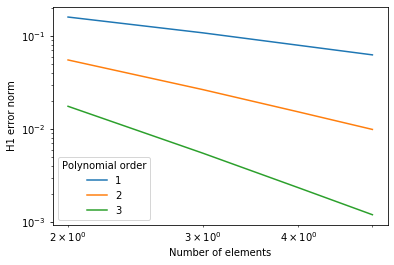

In [5]:
for k in kvec:
    plt.loglog(Nvec, err_dict[k],label=k)
    slope, _ = np.polyfit(np.log(Nvec), np.log(err_dict[k]), 1)
    print(f"Convergence rate (fitted) of the error in the H1 norm for poly order (k={k}) is {-slope}")
    
plt.xlabel('Number of elements')
plt.ylabel('H1 error norm')
plt.legend(title="Polynomial order")
plt.show()

As expected, the H1 error converges on the order of $h$, $h^2$, and $h^3$ for polynomial bases orders of $1$, $2$, and $3$, respectively.

# Problem 2 - Using Gateaux Derivative to Derive Jacobian

$$
\begin{align}
d\psi(u;v) &= (f_0, v) \\
R &= 0 = d\psi(u;v) - (f_0, v)
\end{align}
$$

Where $\psi$ is the energy potential function

In [6]:
from ufl import indices

Attempt 2: Modified $C_{ijkl}$ to match the definition $S_{ij} = C_{ijkl} E_{kl}$. Corrected definition of Jacobian.

In [7]:
N = 8
mesh = UnitCubeMesh(N,N,N)
X = SpatialCoordinate(mesh) 
dx = dx(metadata ={'quadrature_degree':2})
V = VectorFunctionSpace(mesh,"CG",1)

du = TrialFunction(V)
u = Function(V)
v = TestFunction(V)

def manual_problem(u):
    i,j,s = indices(3) # s is a dummy index

    K = Constant(1.0)
    mu = Constant(1.0)
    I = Identity(len(u))
    F = as_tensor(I[i,j] + u[i].dx(j), (i,j))#I + grad(u) # deformation gradient
    C = as_tensor(F[s,j]*F[s,i], (i,j))
    E = as_tensor(0.5*(C[i,j]-I[i,j]), (i,j)) # Green-Lagrange Strain tensor
    S = as_tensor(K*tr(E)*I[i,j] + 2.0*mu*(E[i,j] - tr(E)*I[i,j]/3.0), (i,j)) # 2nd PK Stress tensor
    psi = 0.5*E[i,j]*S[i,j]
    return F,S,psi

F,S,psi = manual_problem(u)
u_ex = as_vector(3*[0.1*sin(pi*X[0]) * sin(pi*X[1])*sin(pi*X[2]) ,]) 
F_ex, S_ex, psi_ex = manual_problem(u_ex)
P_ex = F_ex * S_ex
f0 = -div(P_ex) # using manufactured solution
#R = derivative(psi,u,v)*dx - inner(f0,v)*dx
R = (inner(S,grad(v)) - inner(f0,v))*dx
bc = DirichletBC(V, Constant((0 ,0 ,0)) ,"on_boundary")

def manual_jacobian(u,V): 
    du = TrialFunction(V)
    v = TestFunction(V)
    i,j,k,l,s = indices(5) # s is a dummy index
    K = Constant(1.0)
    mu = Constant(1.0)
    I = Identity(len(u))
#     Ctensor = as_tensor(K*I[i,j]*I[k,l] + mu*(I[i,k]*I[j,l] + I[i,l]*I[j,k]), (i,j,k,l)) # rank 4 isotropic tensor 
    Ctensor = as_tensor(K*I[i,j]*I[k,l] + 2*mu*(I[i,k]*I[j,l] - I[i,j]*I[k,l]/3), (i,j,k,l)) # rank 4 isotropic tensor 

    F = as_tensor(I[i,j] + u[i].dx(j), (i,j))#I + grad(u) # deformation gradient
    C = as_tensor(F[s,j]*F[s,i], (i,j))
    E = as_tensor(0.5*(C[i,j]-I[i,j]), (i,j)) # Green-Lagrange Strain tensor
    S = as_tensor(K*tr(E)*I[i,j] + 2.0*mu*(E[i,j] - tr(E)*I[i,j]/3.0), (i,j)) # 2nd PK Stress tensor
#     J = (1/2*(du[s].dx(i)*v[s].dx(j) + du[s].dx(j)*v[s].dx(i))*Ctensor[i,j,k,l]*E[k,l] \
#         + 1/4*(v[i].dx(j)+v[j].dx(i) + u[s].dx(i)*v[s].dx(j) + u[s].dx(j)*v[s].dx(i))*Ctensor[i,j,k,l]*(du[k].dx(l) + du[l].dx(k) + u[s].dx(k)*du[s].dx(l) + u[s].dx(l)*du[s].dx(k)))*dx
    J = ((du[s].dx(i)*v[s].dx(j) + du[s].dx(j)*v[s].dx(i)) * Ctensor[i,j,k,l] * E[k,l] \
    + (v[i].dx(j) + v[j].dx(i) + u[s].dx(i)*v[s].dx(j) + u[s].dx(j)*v[s].dx(i)) * Ctensor[i,j,k,l] * 1/2*(du[k].dx(l) + du[l].dx(k) + u[s].dx(k)*du[s].dx(l) + u[s].dx(l)*du[s].dx(k)))*dx

    return J
J = manual_jacobian(u,V)

In [8]:
A,L = assemble_system(-J, R, bc)
ddu = Function(V)
u = Function(V)
niter = 10

for idx in range(niter):
    solve(A, ddu.vector(), L)
    u.assign(u+ddu)
    
    J = manual_jacobian(u,V)
    F,S,psi = manual_problem(u)
    R = (inner(S,grad(v)) - inner(f0,v))*dx
    #R = derivative(psi,u,v)*dx - inner(f0,v)*dx
    A,L = assemble_system(-J, R, bc)
    print(H1err(u))

0.10291374594957929
0.062491319583452956
0.04653471929017551
0.04230263946251891
0.04220012906279766
0.043085680565422196
0.04401568951459141
0.04477107281472116
0.045335818297202984
0.04574317091953245


H1 error converges... See attached image "manual_gateaux_derivative.jpg" for derivation

<div>
<img style="transform: rotate(90deg)" src="manual_gateaux_derivative.jpg" width="500"/>
</div>

# Problem 3 - Updated Lagrangian Approach

In [9]:
N = 8
mesh = UnitCubeMesh(N,N,N)
x = SpatialCoordinate(mesh) 
dx = Measure('dx', domain=mesh, metadata ={'quadrature_degree':2})
V = VectorFunctionSpace(mesh,"CG",1)

u = Function(V)
v = TestFunction(V)

# Updated -> Total Lagrangian 
# Functions to change coordinates inspired by:
# https://github.com/david-kamensky/mae-207-fea-for-coupled-problems/blob/master/fsi/fitted-fsi-example.py
X = x - u
det_dXdx = det(grad(X)) # dX/dx

def grad_X(f):
    return dot(grad(f), inv(grad(X)))

def div_X(f): # vector valued f
    return tr(grad_X(f))

def div_X_tensor(f): # rank 2 tensor valued f 
    i,j = indices(2)
    return as_tensor(grad_X(f)[i,j,j], i)

def manual_problem_updatedLag(u):
    i,j,s = indices(3) # s is a dummy index

    K = Constant(1.0)
    mu = Constant(1.0)
    I = Identity(len(u))
    F = I + grad_X(u)
    C = as_tensor(F[s,j]*F[s,i], (i,j))
    E = as_tensor(0.5*(C[i,j]-I[i,j]), (i,j)) # Green-Lagrange Strain tensor
    S = as_tensor(K*tr(E)*I[i,j] + 2.0*mu*(E[i,j] - tr(E)*I[i,j]/3.0), (i,j)) # 2nd PK Stress tensor
    psi = 0.5*E[i,j]*S[i,j]
    return F,S,psi

u_ex = as_vector(3*[0.1*sin(pi*X[0]) * sin(pi*X[1])*sin(pi*X[2]) ,]) 
F_ex, S_ex, psi_ex = manual_problem_updatedLag(u_ex)
P_ex = F_ex * S_ex
f0 = -div_X_tensor(P_ex) # using manufactured solution

H1err_updatedLag = lambda u: sqrt(assemble(((u-u_ex)**2 + (div_X(u)-div_X(u_ex))**2)*det_dXdx*dx))

In [10]:
ddu = Function(V)
u = Function(V)
F,S,psi = manual_problem_updatedLag(u)
R = (inner(S,grad_X(v)) - inner(f0,v))*det_dXdx*dx
#R = (derivative(psi,u,v) - inner(f0,v))*det_dXdx*dx
bc = DirichletBC(V, Constant((0 ,0 ,0)) ,"on_boundary")
J = derivative(R,u)
A,L = assemble_system(-J, R, bc)

niter = 10

for idx in range(niter):
    solve(A, ddu.vector(), L)
    u.assign(u+ddu)
    ALE.move(mesh,ddu)
    X = x - u
    det_dXdx = det(grad(X))
    
    F,S,psi = manual_problem_updatedLag(u)
    R = (inner(S,grad_X(v)) - inner(f0,v))*det_dXdx*dx
    #R = (derivative(psi,u,v) - inner(f0,v))*det_dXdx*dx
    J = derivative(R,u)
    A,L = assemble_system(-J, R, bc)
    print(H1err_updatedLag(u))


0.0671111411365495
0.04814920147787176
0.04888383220276121
0.04927490712526424
0.04938154617409646
0.04939346088487754
0.049396689828210036
0.049397125647122904
0.049397210804952484
0.049397236103572696
